# User Classification using Embeddings

**Date:** 4th December 2024

**Dataset:** German Web Tracking

This notebook evaluates different embedding approaches for user identification based on web browsing sequences. We compare several embedding models against traditional feature engineering:

**Embedding Models:**
- OpenAI (`text-embedding-3-small` and `-large`)
- MiniLM
- E5
- TF-IDF (baseline NLP)
  
**Baseline:** Hand-crafted features including temporal patterns, domain metrics, and behavioral patterns

Key findings:
- OpenAI embeddings perform best (F1: 0.80 without PCA, 0.65 with PCA)
- All embedding approaches outperform traditional feature engineering
- Dimensionality reduction via PCA impacts performance but enables fair comparison

The analysis uses logistic regression and random forest classifiers on ~7.1K sequences from 121 users with 20+ samples each.

## Summary
1. Semantic embeddings capture user behavior better than manual features
2. Larger embedding models (OpenAI) provide better user identification
3. High accuracy (83%) possible with full-dimensional embeddings
4. Simple TF-IDF approach insufficient for this task

In [1]:
import sys
import os

sys.path.append(os.path.abspath("../../"))

In [2]:
import pickle
import numpy as np
import pandas as pd

from cybergpt.models.classification import ClassificationEvaluation, PCAReducer
from cybergpt.models.utils import feature_df_to_numpy

## Data

The dataset consists of web browsing sequences that are processed in two ways:

1. **Text Embeddings**: Each sequence is converted to a string which looks like:
```
"Monday 14:15, Visits: google.com (10s) -> youtube.com (89s) -> google.com (32s) -> amazon.de (123s)"
```

2. **Feature Engineering**: Hand-crafted features; see `cybergpt.models.features` for details. They include:
- Temporal patterns (time of day, session duration, etc.)
- Domain-specific metrics (unique domains, domain categories)
- Behavioral patterns (transition times, dwell times)

### Data Generation

In order to generate the required processed data, please run the following:

**Embeddings**

```shell
python -m cybergpt.models.embed.websites \
    --data_csv path/to/raw/data.csv \
    --output_dir data/embeddings \
    --models openai openai-large minilm e5 tfidf \
    --sample_size 200
```

**Features**

```shell
python -m cybergpt.models.features \
    --data_csv path/to/raw/data.csv \
    --output_dir data/features
```

In [3]:
SEQUENCES_PICKLE = "../../data/embeddings/preprocessed_dataset.pkl"
EMBEDDINGS_PICKLES = {
    "openai": "../../data/embeddings/embeddings_openai.pkl",
    "openai-large": "../../data/embeddings/embeddings_openai-large.pkl",
    "tfidf": "../../data/embeddings/embeddings_tfidf.pkl",
    "e5": "../../data/embeddings/embeddings_e5.pkl",
    "minilm": "../../data/embeddings/embeddings_minilm.pkl",
}
FEATURES_PICKLE = "../../data/features/features.pkl"

In [4]:
data = pickle.load(open(SEQUENCES_PICKLE, "rb"))
sequences = data["string_sequences"]
labels = data["labels"]

embeddings = {e: pickle.load(open(p, "rb")) for e, p in EMBEDDINGS_PICKLES.items()}

In [5]:
feature_data = pickle.load(open(FEATURES_PICKLE, "rb"))
all_labels = feature_data["labels"]
features = feature_data["features"]
np_features = feature_df_to_numpy(features)

In [6]:
# Align features with embeddings subset
users = pd.Series(labels).drop_duplicates().to_list()
feature_arrays = [
    np.array([f for f, l in zip(np_features, all_labels) if l == u]) for u in users
]
np_features = np.concatenate(feature_arrays)

In [7]:
print("Shapes:")
{"features": np_features.shape} | {k: v.shape for k, v in embeddings.items()}

Shapes:


{'features': (7806, 51),
 'openai': (7806, 1536),
 'openai-large': (7806, 3072),
 'tfidf': (7806, 11387),
 'e5': (7806, 384),
 'minilm': (7806, 384)}

In [8]:
print(f"Number of sequences: {len(labels)}")

Number of sequences: 7806


Remove users with fewer than `MIN_SUPPORT` sequences.

In [9]:
MIN_SUPPORT = 20

In [10]:
few_labels = pd.Series(labels).value_counts()
few_labels = list(few_labels[few_labels < MIN_SUPPORT].index)

In [11]:
np_features = np.array([f for f, l in zip(np_features, labels) if l not in few_labels])
embeddings = {
    k: np.array([e for e, l in zip(embs, labels) if l not in few_labels])
    for k, embs in embeddings.items()
}
labels = [l for l in labels if l not in few_labels]

In [12]:
print(f"Remaining number of users: {pd.Series(labels).nunique()}")
print(f"Remaining number of sequences: {len(labels)}")

Remaining number of users: 121
Remaining number of sequences: 7126


## Classification Results

### Methodolody

- The results below are for 121 randomly selected users.
  - Users with fewer than 20 sequences have been filtered out (leaving 121 from an initial randomly-sampled 200 users).
- We consider 5 embedding models:
  - OpenAI: `text-embedding-3-small` and `-large`
  - MiniLM
  - E5
  - TF-IDF as a baseline NLP method
- The baseline corresponds to the hand-crafted features described above.
- For embedding models, PCA reduction is applied to match baseline feature dimensionality (51 dimensions).
- Two classifiers for predicting the `user_id` are evaluated:
  - Multinomial Logistic Regression
  - Random Forest
- Evaluation metrics:
  - On test set: 
    - Precision
    - Recall
    - F1 score
    - Accuracy
  - Stratified 5-fold cross-validation for accuracy on training set

In [13]:
results = {}
y = np.array(labels)
train_indices = None
cv_splits = None

In [14]:
# Sanity check
np_sanity = np.random.permutation(np_features)

print("Sanity Check (Random)")
print("-" * len("Sanity Check (Random)"))

X = np_sanity
evaluator = ClassificationEvaluation(X, y, train_indices, cv_splits)
evaluator.prepare_data()
results["sanity_check"] = evaluator.evaluate_models()

train_indices = evaluator.train_indices
cv_splits = evaluator.cv_splits

print("")

Sanity Check (Random)
---------------------

Evaluating logistic...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for logistic:
accuracy: 0.015427769985974754
macro avg: {'precision': 0.005338296125402255, 'recall': 0.007839479523907535, 'f1-score': 0.005368015997625483, 'support': 1426.0}
weighted avg: {'precision': 0.00795984323957023, 'recall': 0.015427769985974754, 'f1-score': 0.008630932068698074, 'support': 1426.0}

Cross-validation scores: 0.017 (+/- 0.008)

Evaluating rf...

Classification Report for rf:
accuracy: 0.015427769985974754
macro avg: {'precision': 0.010232930269329966, 'recall': 0.010622518027591845, 'f1-score': 0.0101346275572518, 'support': 1426.0}
weighted avg: {'precision': 0.013690506103269866, 'recall': 0.015427769985974754, 'f1-score': 0.013995555916872413, 'support': 1426.0}

Cross-validation scores: 0.013 (+/- 0.003)



/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
print("Features Baseline")
print("-" * len("Features Baseline"))

X = np_features
evaluator = ClassificationEvaluation(X, y, train_indices, cv_splits)
evaluator.prepare_data()
results["baseline"] = evaluator.evaluate_models()

train_indices = evaluator.train_indices
cv_splits = evaluator.cv_splits

print("")

Features Baseline
-----------------

Evaluating logistic...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for logistic:
accuracy: 0.34642356241234223
macro avg: {'precision': 0.30078801835907654, 'recall': 0.284580111476388, 'f1-score': 0.2731764692112418, 'support': 1426.0}
weighted avg: {'precision': 0.332460280125103, 'recall': 0.34642356241234223, 'f1-score': 0.31990827531784954, 'support': 1426.0}

Cross-validation scores: 0.324 (+/- 0.013)

Evaluating rf...

Classification Report for rf:
accuracy: 0.3330995792426367
macro avg: {'precision': 0.24888313732675313, 'recall': 0.2607358160188536, 'f1-score': 0.24653739434487468, 'support': 1426.0}
weighted avg: {'precision': 0.2980868929929131, 'recall': 0.3330995792426367, 'f1-score': 0.30497780102005523, 'support': 1426.0}

Cross-validation scores: 0.316 (+/- 0.018)



/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
PROJ_DIM = np_features.shape[1]
PROJ_DIM

51

Model: openai
-------------


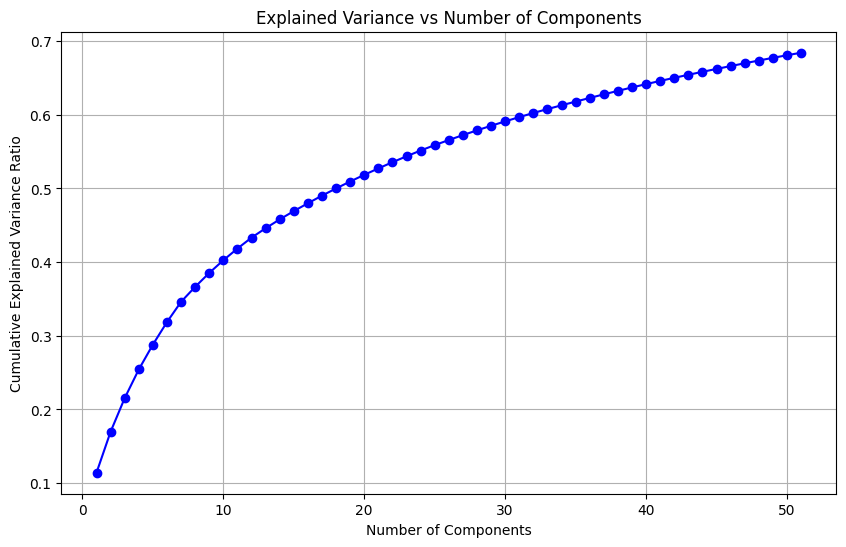

Original shape: (7126, 1536)
Reduced shape: (7126, 51)
Total explained variance ratio: 0.684

Evaluating logistic...

Classification Report for logistic:
accuracy: 0.7159887798036466
macro avg: {'precision': 0.6643320507937097, 'recall': 0.6455209933988627, 'f1-score': 0.6454036726810647, 'support': 1426.0}
weighted avg: {'precision': 0.7181695754801354, 'recall': 0.7159887798036466, 'f1-score': 0.7094972928260516, 'support': 1426.0}

Cross-validation scores: 0.727 (+/- 0.021)

Evaluating rf...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for rf:
accuracy: 0.6900420757363254
macro avg: {'precision': 0.6553595608289825, 'recall': 0.5942162376801616, 'f1-score': 0.5977157621256035, 'support': 1426.0}
weighted avg: {'precision': 0.6873484509909272, 'recall': 0.6900420757363254, 'f1-score': 0.6690374389905006, 'support': 1426.0}

Cross-validation scores: 0.673 (+/- 0.021)

Model: openai-large
-------------------


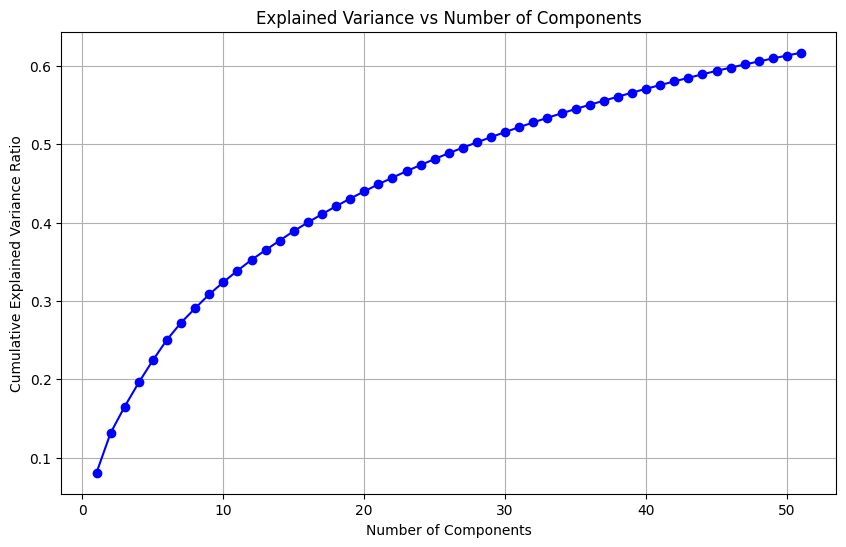

Original shape: (7126, 3072)
Reduced shape: (7126, 51)
Total explained variance ratio: 0.617

Evaluating logistic...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for logistic:
accuracy: 0.7328190743338009
macro avg: {'precision': 0.6972924097657204, 'recall': 0.6619488471381433, 'f1-score': 0.6622149008856832, 'support': 1426.0}
weighted avg: {'precision': 0.7460216502835405, 'recall': 0.7328190743338009, 'f1-score': 0.7284099917160886, 'support': 1426.0}

Cross-validation scores: 0.728 (+/- 0.013)

Evaluating rf...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for rf:
accuracy: 0.6669004207573632
macro avg: {'precision': 0.6307444099306269, 'recall': 0.5675393194807118, 'f1-score': 0.5682445782862253, 'support': 1426.0}
weighted avg: {'precision': 0.67240813690361, 'recall': 0.6669004207573632, 'f1-score': 0.645639529901088, 'support': 1426.0}

Cross-validation scores: 0.666 (+/- 0.022)

Model: tfidf
------------


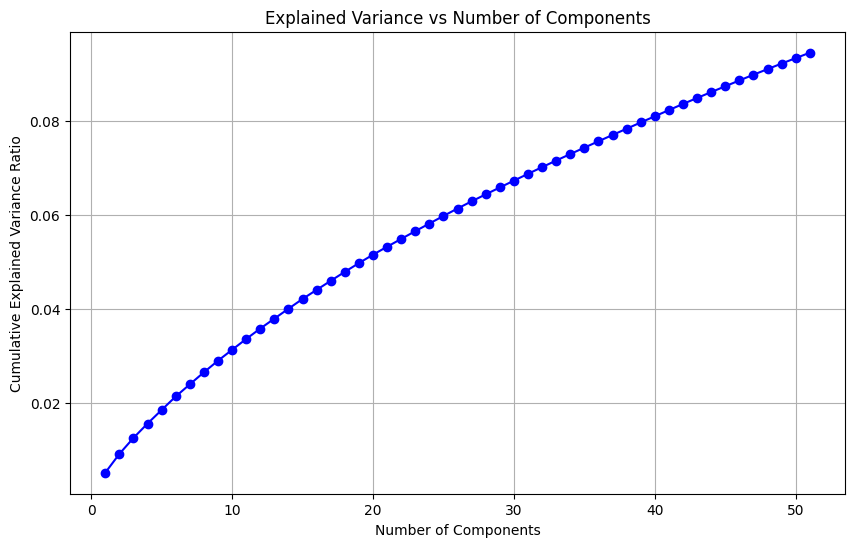

Original shape: (7126, 11387)
Reduced shape: (7126, 51)
Total explained variance ratio: 0.094

Evaluating logistic...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for logistic:
accuracy: 0.226507713884993
macro avg: {'precision': 0.19573263287832302, 'recall': 0.1621245162551318, 'f1-score': 0.14706162530700548, 'support': 1426.0}
weighted avg: {'precision': 0.21094073878259167, 'recall': 0.226507713884993, 'f1-score': 0.17136020887980136, 'support': 1426.0}

Cross-validation scores: 0.231 (+/- 0.007)

Evaluating rf...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for rf:
accuracy: 0.39691444600280507
macro avg: {'precision': 0.35037658021951984, 'recall': 0.32779514046351127, 'f1-score': 0.31103289057659533, 'support': 1426.0}
weighted avg: {'precision': 0.36767534015107134, 'recall': 0.39691444600280507, 'f1-score': 0.35477342636901477, 'support': 1426.0}

Cross-validation scores: 0.407 (+/- 0.020)

Model: e5
---------


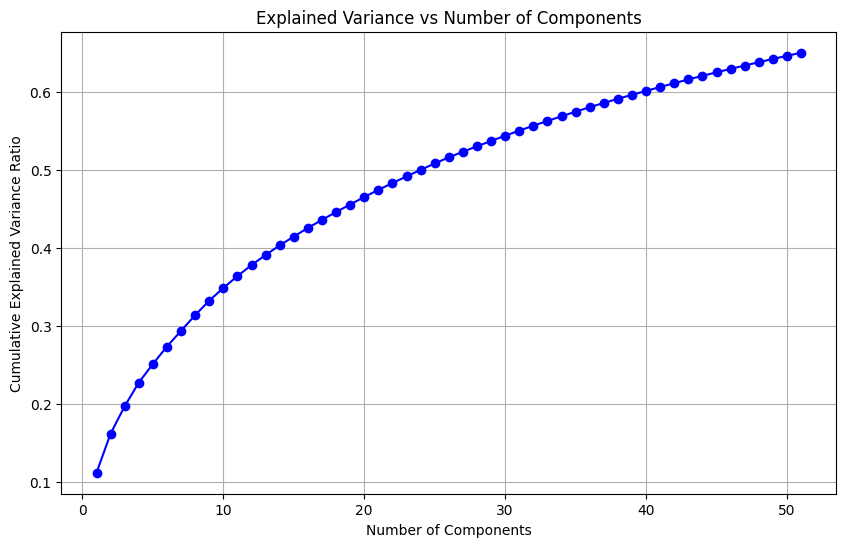

Original shape: (7126, 384)
Reduced shape: (7126, 51)
Total explained variance ratio: 0.651

Evaluating logistic...

Classification Report for logistic:
accuracy: 0.6388499298737728
macro avg: {'precision': 0.5715202982517469, 'recall': 0.5537525548102535, 'f1-score': 0.5503467059043958, 'support': 1426.0}
weighted avg: {'precision': 0.6440518749546928, 'recall': 0.6388499298737728, 'f1-score': 0.6324594007934983, 'support': 1426.0}

Cross-validation scores: 0.632 (+/- 0.024)

Evaluating rf...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for rf:
accuracy: 0.5701262272089762
macro avg: {'precision': 0.49078383067574705, 'recall': 0.45947843544281275, 'f1-score': 0.45117414337259315, 'support': 1426.0}
weighted avg: {'precision': 0.5442041322003033, 'recall': 0.5701262272089762, 'f1-score': 0.5373930074612749, 'support': 1426.0}

Cross-validation scores: 0.569 (+/- 0.018)

Model: minilm
-------------


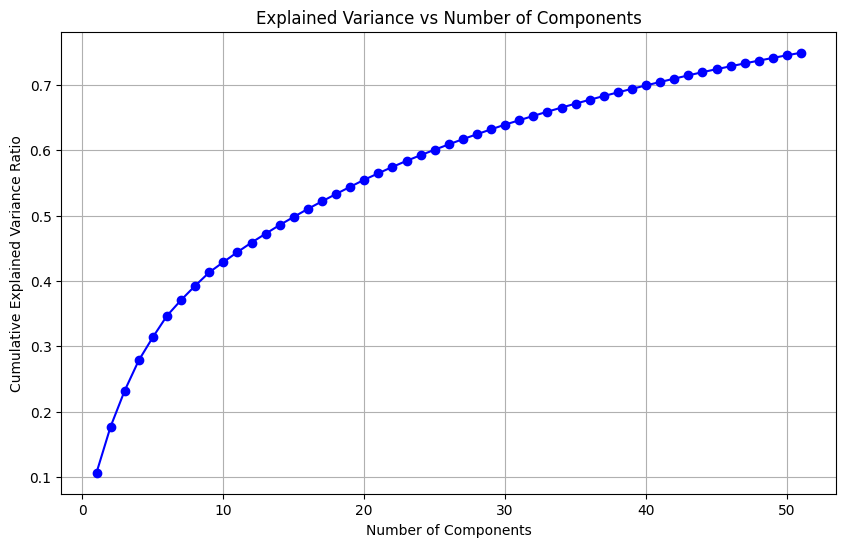

Original shape: (7126, 384)
Reduced shape: (7126, 51)
Total explained variance ratio: 0.749

Evaluating logistic...

Classification Report for logistic:
accuracy: 0.6493688639551192
macro avg: {'precision': 0.6024962823680752, 'recall': 0.5830235239781728, 'f1-score': 0.5812984322840561, 'support': 1426.0}
weighted avg: {'precision': 0.6579624711964661, 'recall': 0.6493688639551192, 'f1-score': 0.6454033061009402, 'support': 1426.0}

Cross-validation scores: 0.644 (+/- 0.016)

Evaluating rf...

Classification Report for rf:
accuracy: 0.5932678821879382
macro avg: {'precision': 0.5371567206184288, 'recall': 0.4883275025203185, 'f1-score': 0.4828448470001771, 'support': 1426.0}
weighted avg: {'precision': 0.5828372532556866, 'recall': 0.5932678821879382, 'f1-score': 0.5643061189890644, 'support': 1426.0}

Cross-validation scores: 0.604 (+/- 0.010)



/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
y = np.array(labels)
for model, embs in embeddings.items():
    print(f"Model: {model}")
    print("-" * len(f"Model: {model}"))

    X = embs
    X_train = X[train_indices, :]
    reducer = PCAReducer()
    reducer.fit(X_train, PROJ_DIM)
    _ = reducer.analyze_explained_variance()

    X_reduced = reducer.reduce_dimensions(X)

    evaluator = ClassificationEvaluation(X_reduced, y, train_indices, cv_splits)
    evaluator.prepare_data()
    results[model] = evaluator.evaluate_models()

    train_indices = evaluator.train_indices
    cv_splits = evaluator.cv_splits

    print("")

In [19]:
output = {
    "results": results,
    "labels": labels,
}
pickle.dump(output, open("../../data/embeddings/results.pkl", "wb"))

### Results Summary

**Logistic Regression**
- OpenAI embeddings significantly outperform other approaches (F1: 0.65-0.66)
- MiniLM and E5 show moderate performance (F1: 0.55-0.58)
- Hand-crafted features perform poorly (F1: 0.27)
- TF-IDF performs worst (F1: 0.15)

**Random Forest Performance**
- Similar pattern but slightly lower scores overall
- OpenAI embeddings still lead (F1: 0.57-0.60)
- Larger gap between embedding models and baseline

In the results tables below, `sanity_check` indicates the results when we randomly permute the features table.

In [20]:
def summary(model):
    return (
        pd.DataFrame(
            {
                k: {
                    f"mean_{m}": v
                    for m, v in results[k][model]["classification_report"][
                        "macro avg"
                    ].items()
                }
                | {
                    "accuracy": results[k][model]["classification_report"]["accuracy"],
                    "mean_cv_score": np.mean(results[k][model]["cv_scores"]),
                }
                for k in results
            }
        )
        .T.sort_values("mean_f1-score", ascending=False)
        .round(3)
        .drop("mean_support", axis=1)
        .rename(
            columns={
                "mean_precision": "Mean Precision",
                "mean_recall": "Mean Recall",
                "mean_f1-score": "Mean F1 Score",
                "accuracy": "Mean Accuracy",
                "mean_cv_score": "Mean CV Score",
            }
        )
        .style.format("{:.3f}")
        .highlight_max(axis=0, color="lightgreen")
        .set_properties(**{"text-align": "center"})
        .set_table_styles(
            [
                {"selector": "th", "props": [("text-align", "center")]},
                {"selector": "", "props": [("border", "1px solid grey")]},
                {"selector": "th,td", "props": [("padding", "8px")]},
            ]
        )
    )

In [21]:
summary("logistic")

,Mean Precision,Mean Recall,Mean F1 Score,Mean Accuracy,Mean CV Score
openai-large,0.697,0.662,0.662,0.733,0.728
openai,0.664,0.646,0.645,0.716,0.727
minilm,0.602,0.583,0.581,0.649,0.644
e5,0.572,0.554,0.550,0.639,0.632
baseline,0.301,0.285,0.273,0.346,0.324
tfidf,0.196,0.162,0.147,0.227,0.231
sanity_check,0.005,0.008,0.005,0.015,0.017


In [22]:
summary("rf")

,Mean Precision,Mean Recall,Mean F1 Score,Mean Accuracy,Mean CV Score
openai,0.655,0.594,0.598,0.690,0.673
openai-large,0.631,0.568,0.568,0.667,0.666
minilm,0.537,0.488,0.483,0.593,0.604
e5,0.491,0.459,0.451,0.570,0.569
tfidf,0.350,0.328,0.311,0.397,0.407
baseline,0.249,0.261,0.247,0.333,0.316
sanity_check,0.010,0.011,0.010,0.015,0.013


### Without PCA Reduction

Look at difference in performance for `openai-large` embeddings when we don't apply PCA.

- Significant performance improvement (F1: 0.80 vs 0.65)
- Accuracy increases from 72% to 83%
- Suggests more informational content than the dimensionality of the hand-crafted features

In [23]:
model = "openai-large"

y = np.array(labels)
X = embeddings[model]
X_train = X[train_indices, :]

evaluator = ClassificationEvaluation(X, y, train_indices, cv_splits)
evaluator.prepare_data()
results_full_dim = evaluator.evaluate_models(model_names=["logistic"])


Evaluating logistic...

Classification Report for logistic:
accuracy: 0.8288920056100981
macro avg: {'precision': 0.8301192614219481, 'recall': 0.7917252123996884, 'f1-score': 0.7966813299727359, 'support': 1426.0}
weighted avg: {'precision': 0.8468358384369494, 'recall': 0.8288920056100981, 'f1-score': 0.8281786445883221, 'support': 1426.0}

Cross-validation scores: 0.812 (+/- 0.012)


In [24]:
pd.DataFrame(
    {
        k: {f"mean_{m}": v for m, v in r["classification_report"]["macro avg"].items()}
        | {
            "accuracy": r["classification_report"]["accuracy"],
            "mean_cv_score": np.mean(r["cv_scores"]),
        }
        for k, r in [
            ("With PCA", results["openai"]["logistic"]),
            ("Without PCA", results_full_dim["logistic"]),
        ]
    }
).T.sort_values("mean_f1-score", ascending=False).round(3).drop(
    "mean_support", axis=1
).rename(
    columns={
        "mean_precision": "Mean Precision",
        "mean_recall": "Mean Recall",
        "mean_f1-score": "Mean F1 Score",
        "accuracy": "Mean Accuracy",
        "mean_cv_score": "Mean CV Score",
    }
).style.format(
    "{:.3f}"
).highlight_max(
    axis=0, color="lightgreen"
).set_properties(
    **{"text-align": "center"}
).set_table_styles(
    [
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "", "props": [("border", "1px solid grey")]},
        {"selector": "th,td", "props": [("padding", "8px")]},
    ]
)

,Mean Precision,Mean Recall,Mean F1 Score,Mean Accuracy,Mean CV Score
Without PCA,0.830,0.792,0.797,0.829,0.812
With PCA,0.664,0.646,0.645,0.716,0.727
